In [24]:
import numpy as np
import pandas as pd

EPOCHS = 100

targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
num = [1000, 2000, 5000]

dataframes = {
    target: pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{target}.csv')
    for target in targets
}

dataframes["Unconditional"] = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/Unconditional.csv')

for target in dataframes:
    df = dataframes[target]
    col_preds = df.columns[1]

    count_invalid = len(df[df[col_preds].isna()])
    print(f"{target}: {count_invalid}")

    # Drop invalid smiles rows
    dataframes[target] = df.dropna(subset=[col_preds]).copy()
    # Set dtype as float for every column except SMILES
    for col in df.columns:
        if col != 'SMILES':
            dataframes[target][col] = dataframes[target][col].astype(float)

    print(dataframes[target].shape)

_5HT2A: 4165
(25835, 7)
AChE: 5500
(24500, 7)
D2R: 3943
(26057, 11)
D3R: 3955
(26045, 7)
MAOB: 3543
(26457, 7)
Unconditional: 3910
(26090, 17)


In [25]:
aggs = ["SUM", "MEAN", "MAX"]
# aggs = ["MEAN", "MAX"]
# aggs = ["SUM"]

multi_targets = list()

for agg in aggs:
    multi_targets.extend([
        f"AChE_MAOB_{agg}",
        f"D2R__5HT2A_{agg}",
        f"D2R_D3R_{agg}"
    ])

dataframes_mt = {
    targets: pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{targets}.csv')
    for targets in multi_targets
}

for mts in dataframes_mt:
    df = dataframes_mt[mts]

    col_preds = df.columns[1]

    count_invalid = len(df[df[col_preds].isna()])
    print(f"{mts}: {count_invalid}")

    # Drop invalid smiles rows
    dataframes_mt[mts] = df.dropna(subset=[col_preds]).copy()
    # Set dtype as float for every column except SMILES
    for col in df.columns:
        if col != 'SMILES':
            dataframes_mt[mts][col] = dataframes_mt[mts][col].astype(float)
    
    print(dataframes_mt[mts].shape)

AChE_MAOB_SUM: 5063
(24937, 7)
D2R__5HT2A_SUM: 4279
(25721, 7)
D2R_D3R_SUM: 4147
(25853, 7)
AChE_MAOB_MEAN: 4107
(25893, 7)
D2R__5HT2A_MEAN: 3978
(26022, 7)
D2R_D3R_MEAN: 3904
(26096, 7)
AChE_MAOB_MAX: 4047
(25953, 7)
D2R__5HT2A_MAX: 3976
(26024, 7)
D2R_D3R_MAX: 3840
(26160, 7)


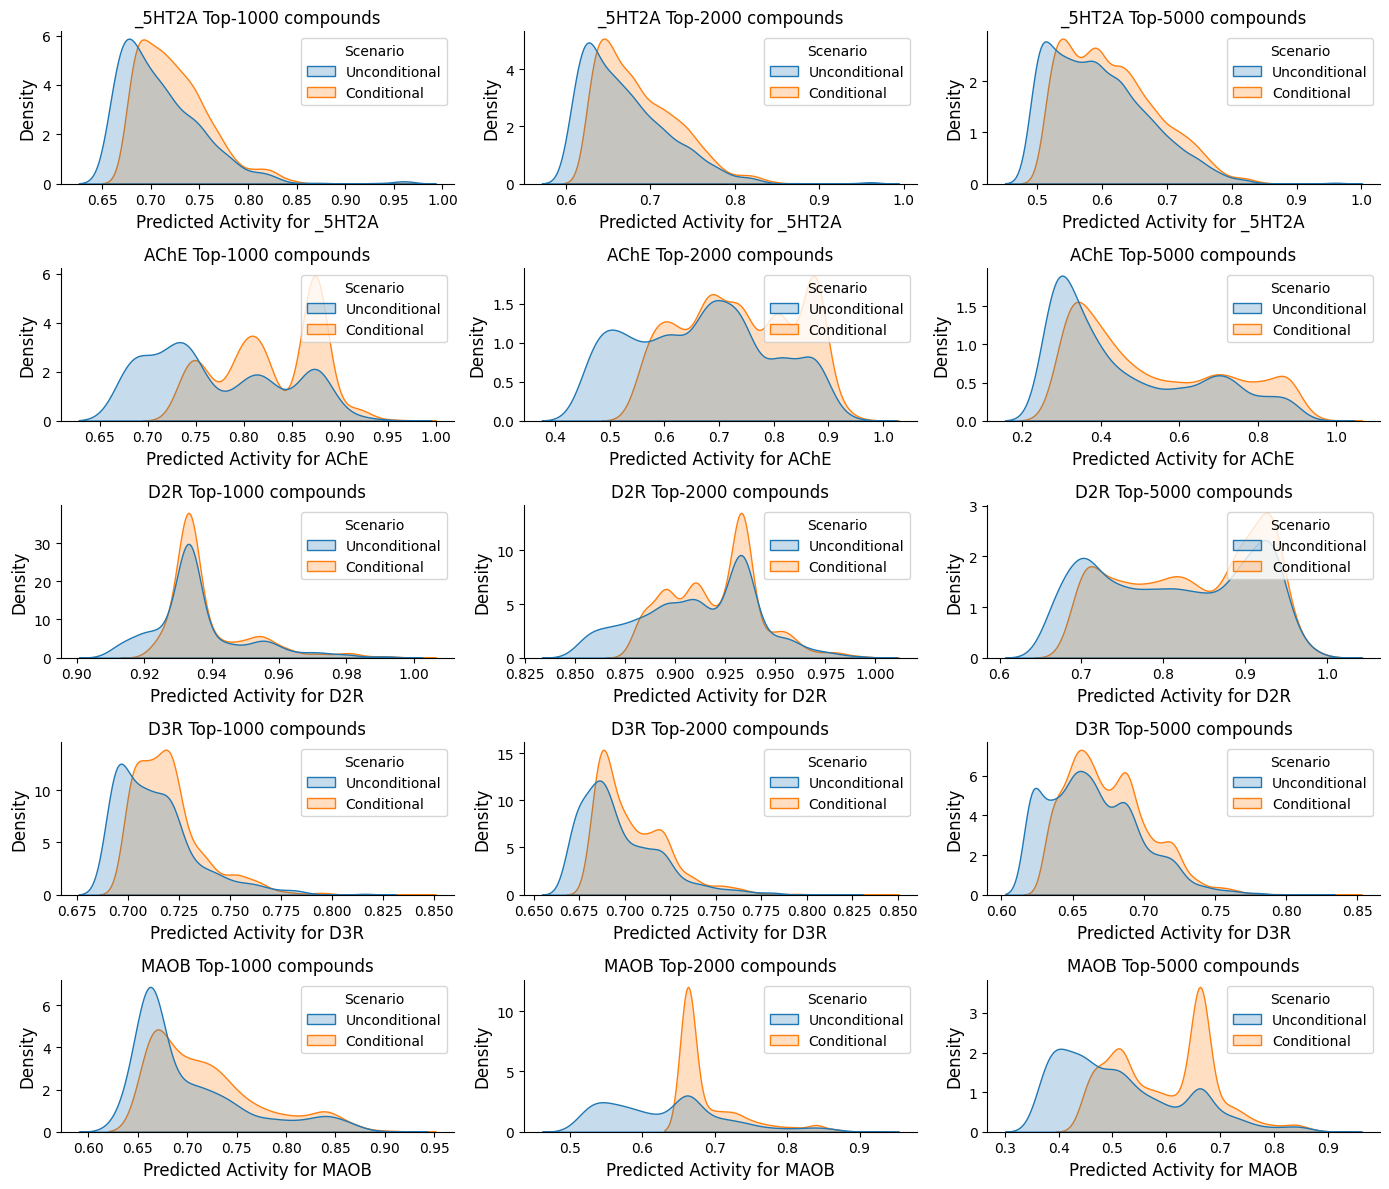

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

ACT_TYPE = "Activity" 
# ACT_TYPE = "pIC50"
# ACT_TYPE = "inhibition"

pal=list(sns.color_palette("tab10"))
fig, axes = plt.subplots(len(targets), len(num), figsize=(14, 12))

for i, name in enumerate(targets):
    for j, n in enumerate(num):
        activity_column = f"{name}_{ACT_TYPE}"
        unconditional = dataframes["Unconditional"][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario="Unconditional")

        conditional = dataframes[name][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario="Conditional")

        activities = pd.concat([unconditional, conditional]).reset_index()

        sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[i, j], fill=True)
        # sns.histplot(data=activities, x=activity_column, hue='Scenario',ax=axes[i, j], fill=True)

        axes[i, j].set_title('{} Top-{} compounds'.format(name, n), fontsize=12)
        axes[i, j].spines['right'].set_visible(False)
        axes[i, j].spines['top'].set_visible(False)
        axes[i, j].set_ylabel("Density", fontsize=12)
        axes[i, j].set_xlabel(f"Predicted {ACT_TYPE} for {name}", fontsize=12)

    plt.tight_layout()

plt.show()

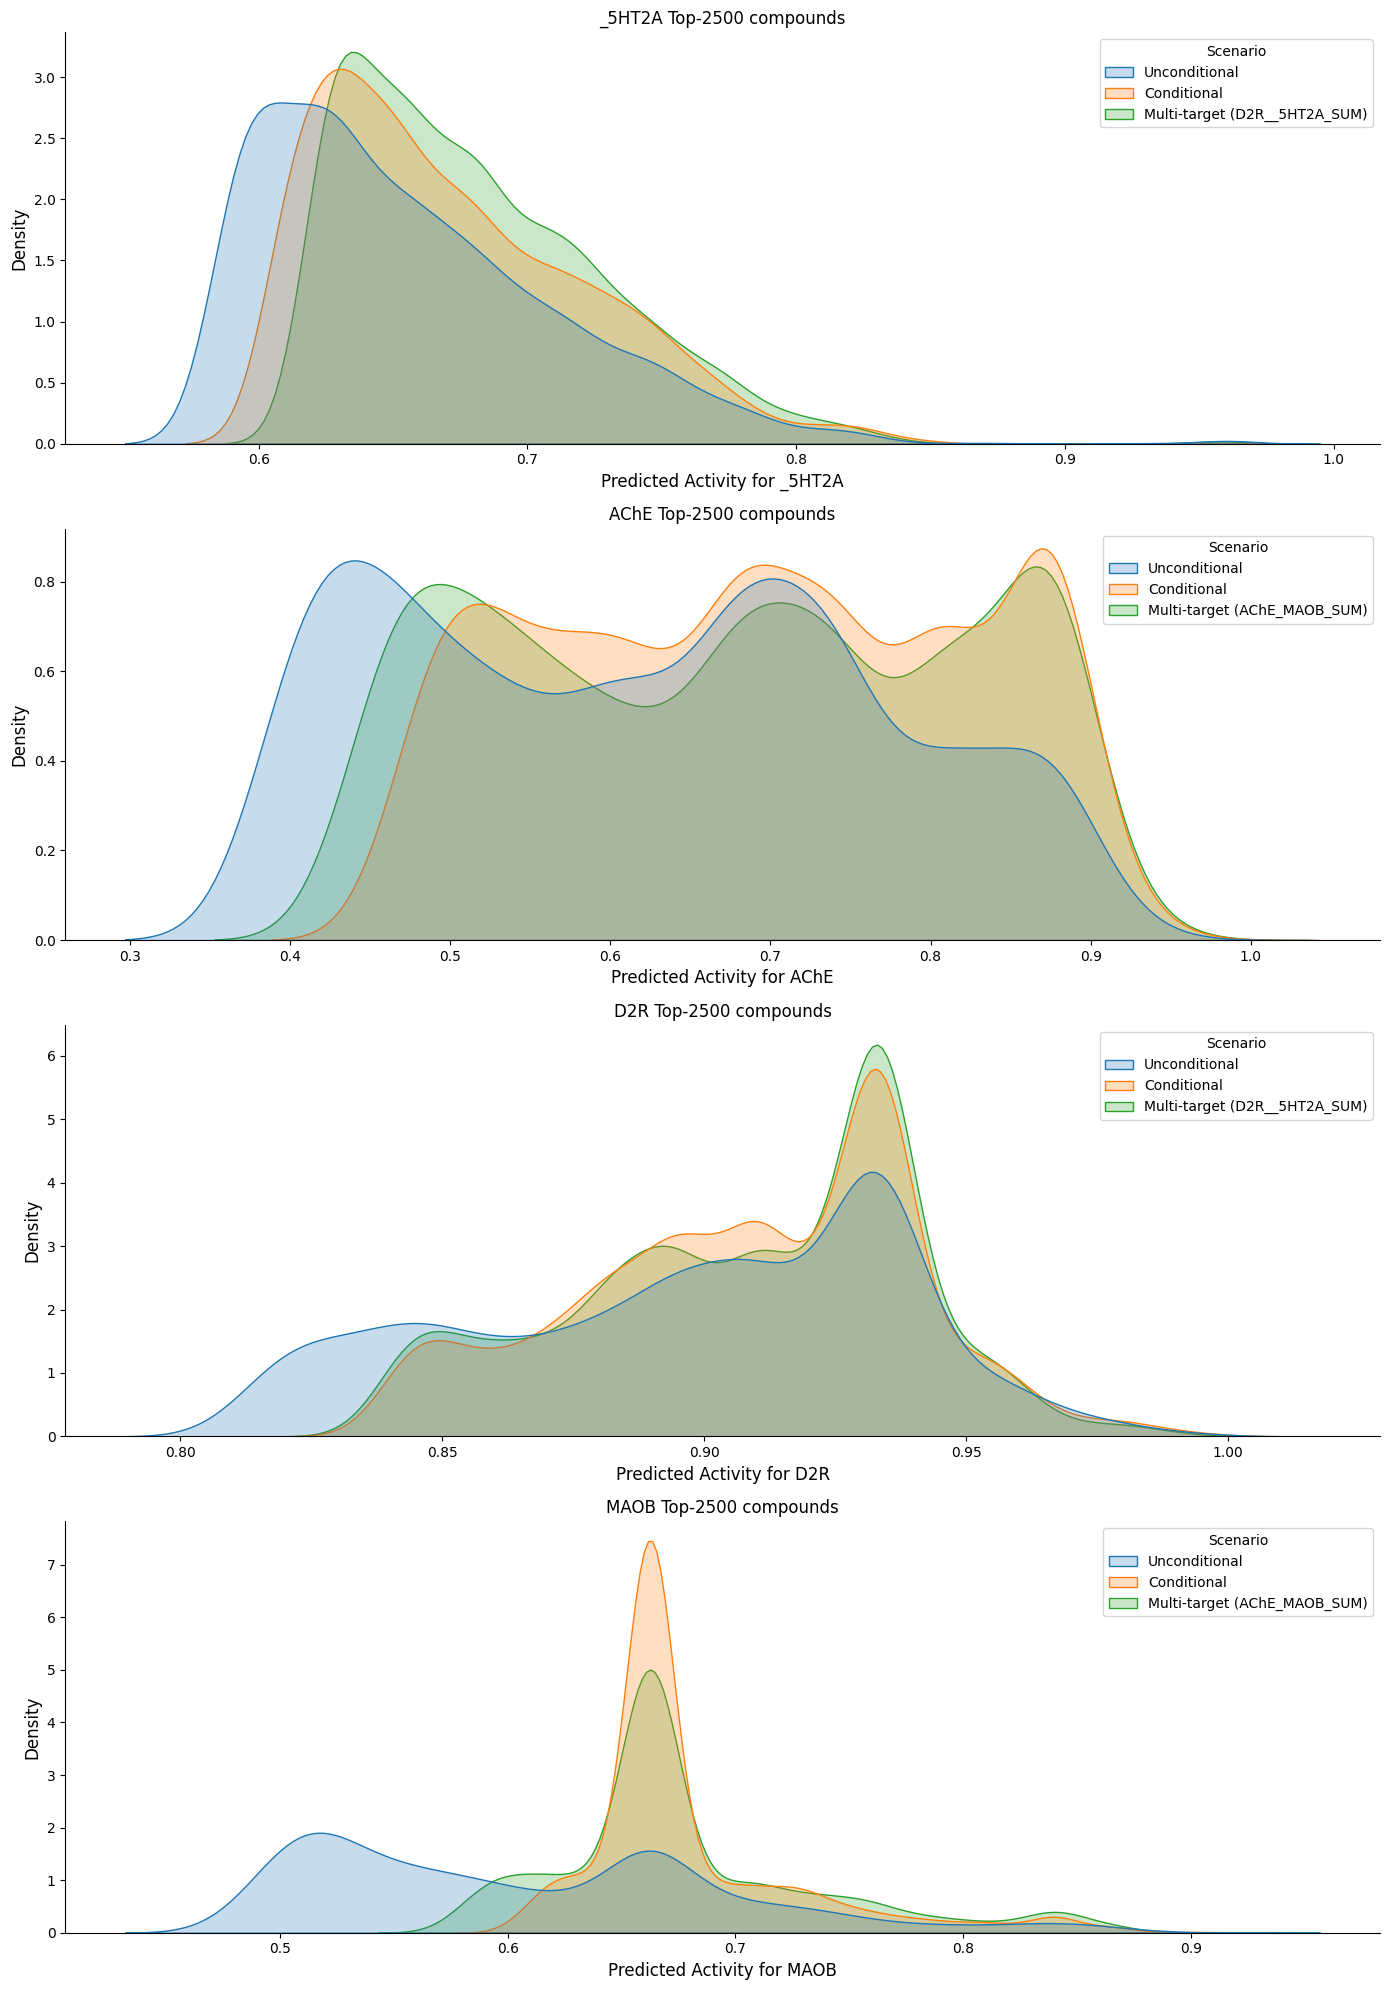

In [27]:
# Plot the multi-target distributions for the top 1000 compounds
agg = "SUM"

multi_targets = [
    f"AChE_MAOB_{agg}",
    f"D2R__5HT2A_{agg}",
    # f"D2R_D3R_{agg}"
]

# targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
targets = ['_5HT2A', 'AChE', 'D2R', 'MAOB']
# targets =  ['AChE', 'MAOB']

fig, axes = plt.subplots(len(targets), 1, figsize=(14, 20))
n = 2500

for j, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()

    sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)
    # sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    axes[j].set_title('{} Top-{} compounds'.format(target, n), fontsize=12)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    axes[j].set_ylabel("Density", fontsize=12)
    axes[j].set_xlabel(f"Predicted {ACT_TYPE} for {target}", fontsize=12)

plt.tight_layout()
plt.show()

In [28]:
# !pip install ptitprince

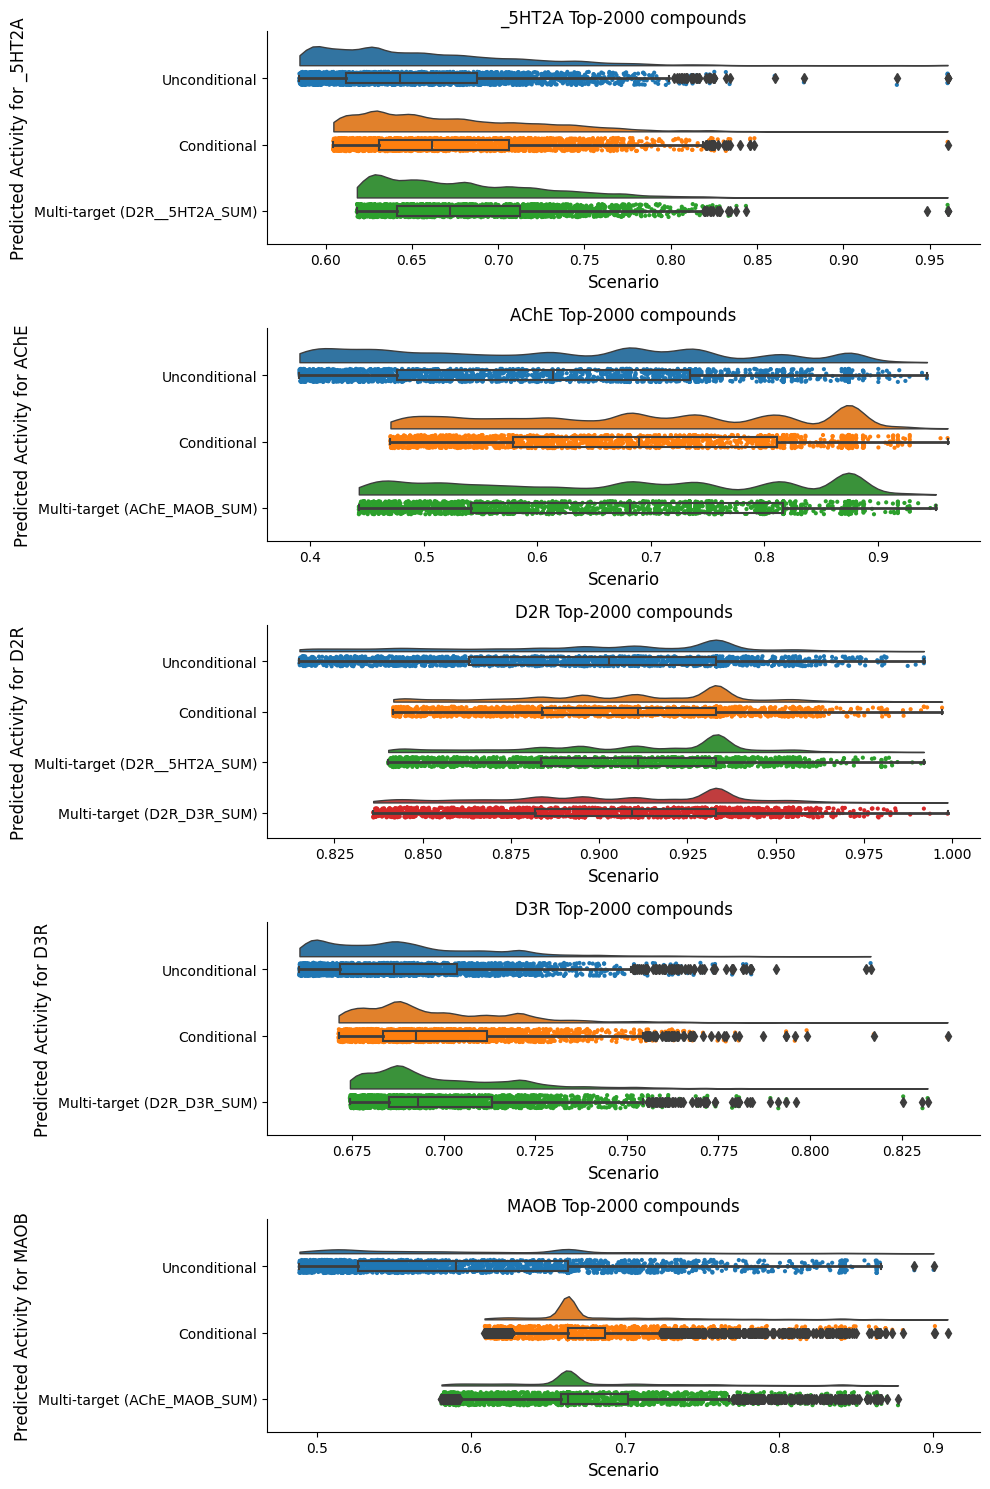

In [29]:
import ptitprince as pt

num = 2000
agg = "SUM"

multi_targets = [
    f"AChE_MAOB_{agg}",
    f"D2R__5HT2A_{agg}",
    f"D2R_D3R_{agg}"
]

targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
# targets = ['_5HT2A', 'AChE', 'D2R', 'MAOB']
# targets =  ['AChE', 'MAOB']

fig, axes = plt.subplots(len(targets), figsize=(10, 15))

for i, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()

    pt.RainCloud(data=activities, x='Scenario', y=activity_column, bw=.1, ax=axes[i], palette=pal, orient = "h")

    axes[i].set_title('{} Top-{} compounds'.format(target, num), fontsize=12)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].set_ylabel(f"Predicted {ACT_TYPE} for {target}", fontsize=12)
    axes[i].set_xlabel("Scenario", fontsize=12)

plt.tight_layout()

plt.show()

In [30]:
for j, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()
    pivot = activities.pivot_table(index='Scenario', values=activity_column, aggfunc=[np.mean, np.std])
    format_str = "{:.2%}" if ACT_TYPE == "Activity" else "{:.2f}"

    # print(f"Target: {target}")
    display(pivot.style
                 .format(format_str)
                 .set_caption(f"Top-{n} {target} {ACT_TYPE} statistics")
                 .background_gradient(cmap='Blues', axis=0))

,mean,std
,_5HT2A_Activity,_5HT2A_Activity
Scenario,,
Conditional,67.27%,5.06%
Multi-target (D2R__5HT2A_SUM),68.14%,4.85%
Unconditional,65.54%,5.52%


,mean,std
,AChE_Activity,AChE_Activity
Scenario,,
Conditional,69.26%,13.06%
Multi-target (AChE_MAOB_SUM),67.54%,14.36%
Unconditional,61.73%,14.89%


,mean,std
,D2R_Activity,D2R_Activity
Scenario,,
Conditional,90.81%,3.16%
Multi-target (D2R_D3R_SUM),90.52%,3.37%
Multi-target (D2R__5HT2A_SUM),90.79%,3.22%
Unconditional,89.61%,4.08%


,mean,std
,D3R_Activity,D3R_Activity
Scenario,,
Conditional,69.88%,2.12%
Multi-target (D2R_D3R_SUM),70.02%,2.15%
Unconditional,69.04%,2.35%


,mean,std
,MAOB_Activity,MAOB_Activity
Scenario,,
Conditional,68.06%,4.91%
Multi-target (AChE_MAOB_SUM),67.86%,5.98%
Unconditional,60.69%,8.96%


### Assess mean target modulation

Unconditional
AChE
MAOB
AChE_MAOB_SUM
Unconditional
D2R
D3R
D2R_D3R_SUM
Unconditional
D2R
_5HT2A
D2R__5HT2A_SUM


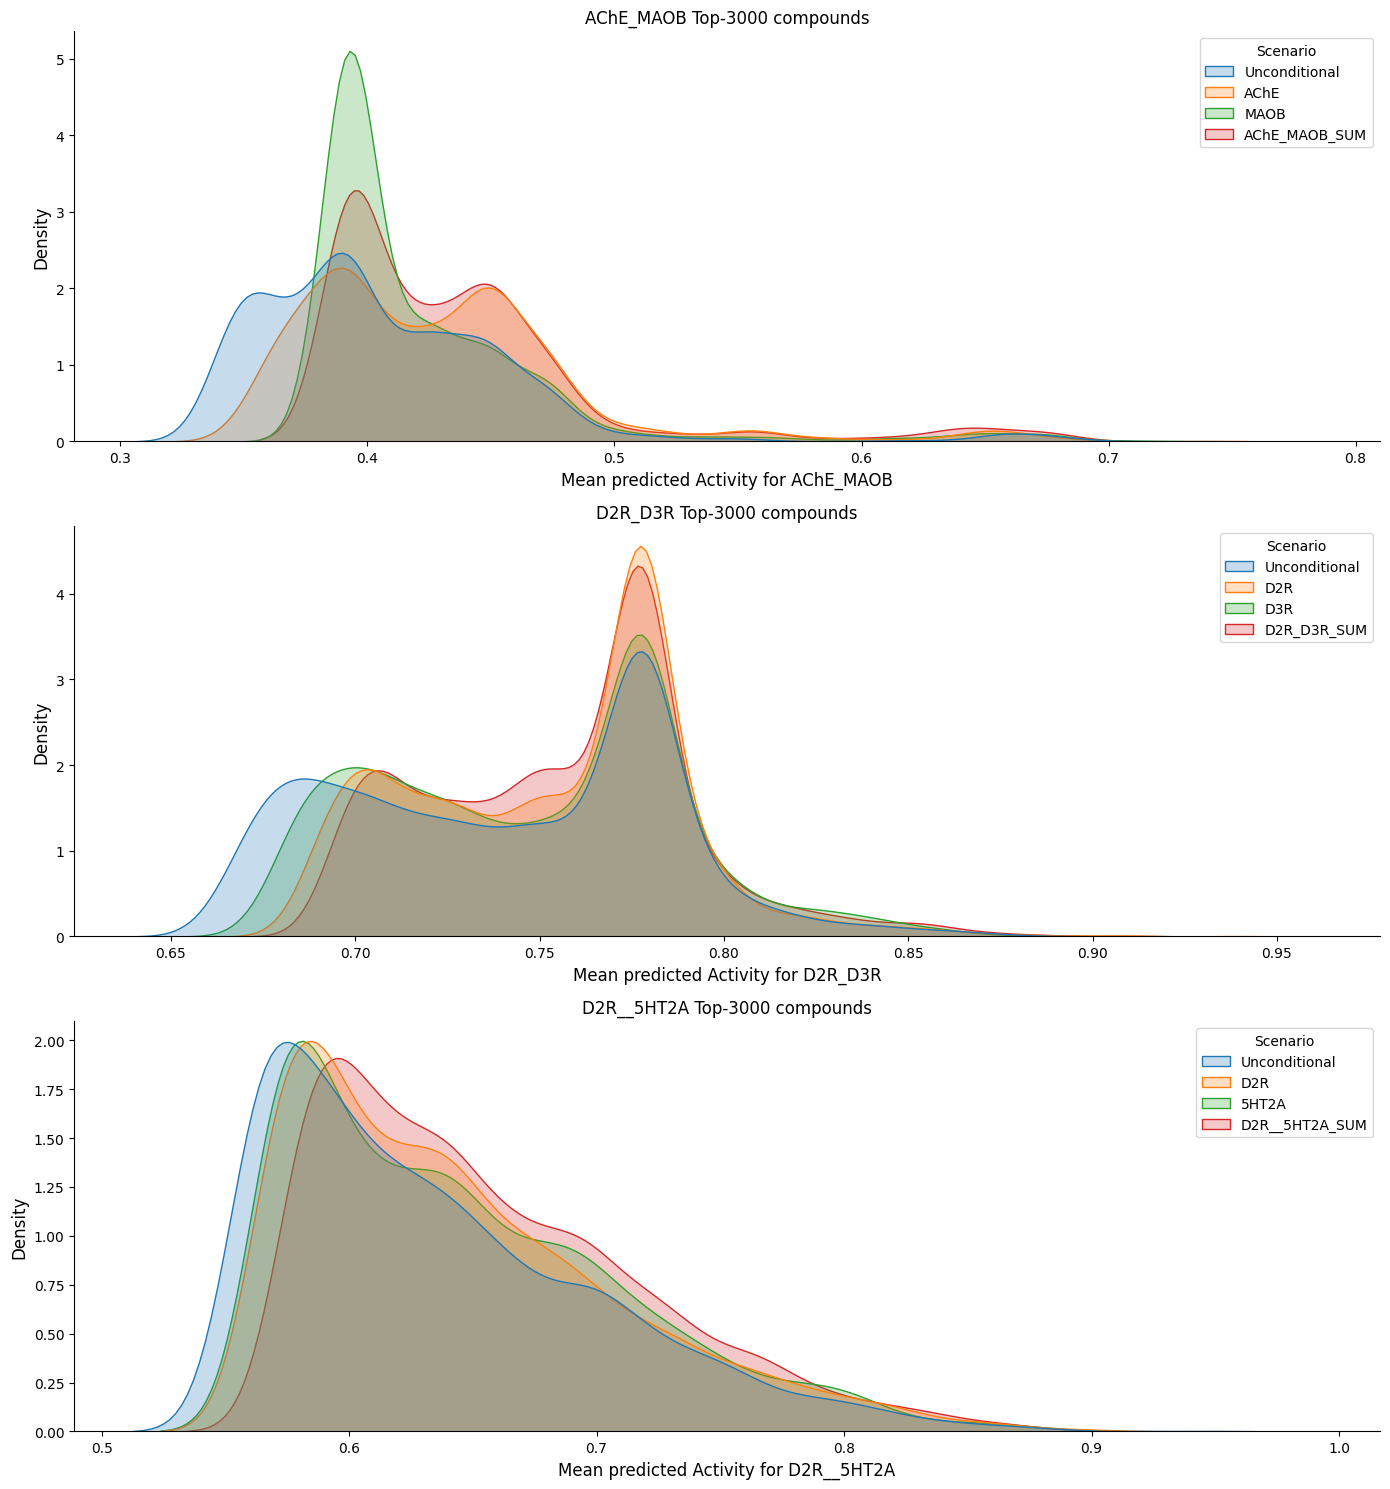

In [31]:
agg = "SUM"  # MEAN, MAX
ACT_TYPE = "Activity"  # pIC50, inhibition
# ACT_TYPE = "inhibition"  # pIC50, inhibition

multitarget_combination = {
    "AChE_MAOB": {
        "generated_molecules": ["Unconditional", "AChE", "MAOB", f"AChE_MAOB_{agg}"],
        # "generated_molecules": ["AChE", "MAOB", f"AChE_MAOB_{agg}"],
        "models": ["AChE", "MAOB"]
    },
    "D2R_D3R": {
        "generated_molecules": ["Unconditional", "D2R", "D3R", f"D2R_D3R_{agg}"],
        # "generated_molecules": [ "D2R", "D3R", f"D2R_D3R_{agg}"],
        "models": ["D2R", "D3R"]
    },
    "D2R__5HT2A": {
        "generated_molecules": ["Unconditional", "D2R", "_5HT2A", f"D2R__5HT2A_{agg}"],
        # "generated_molecules": [ "D2R", "_5HT2A", f"D2R__5HT2A_{agg}"],
        "models": ["D2R", "_5HT2A"]
    },
}

fig, axes = plt.subplots(len(multitarget_combination), 1, figsize=(14, 5 * len(multitarget_combination)))
n = 3000


for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()
    # print(f"Combination: {activity_column}")

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        print(gen_molecule)
        # df = pd.read_csv(f'../generated_molecules/predicted_activity/{gen_molecule}_MTDD.csv')
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)
    # sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    axes[j].set_title('{} Top-{} compounds'.format(combination, n), fontsize=12)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    axes[j].set_ylabel("Density", fontsize=12)
    axes[j].set_xlabel(f"Mean predicted {ACT_TYPE} for {combination}", fontsize=12)

plt.tight_layout()
plt.show()

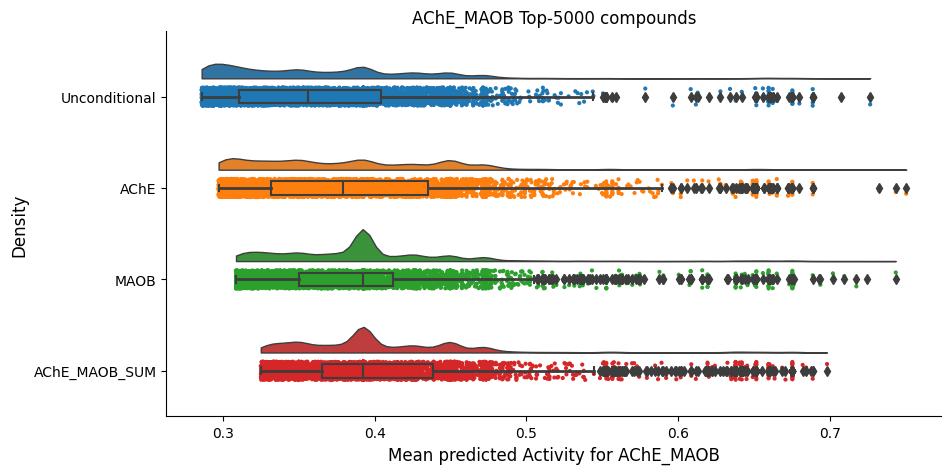

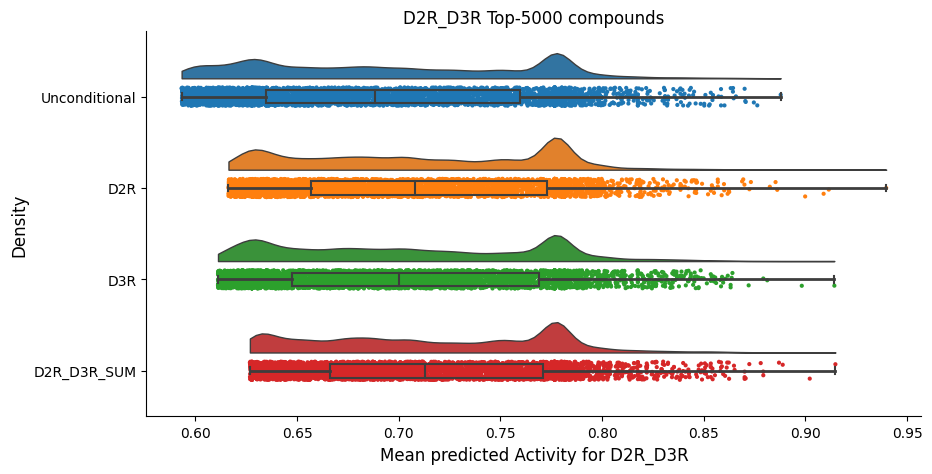

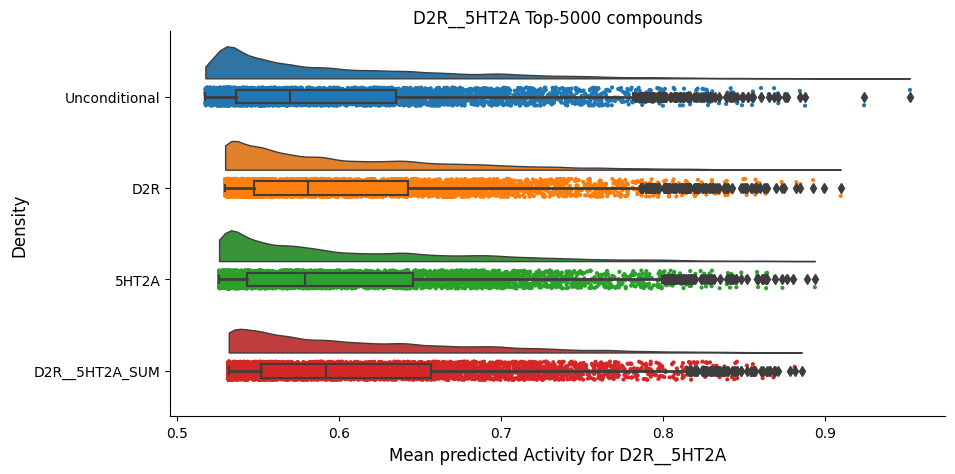

In [32]:
# fig, axes = plt.subplots(len(multitarget_combination), 1, figsize=(10, 5 * len(multitarget_combination)))
n = 5000

for j, (ax, combination) in enumerate(zip(axes, multitarget_combination)):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()
    # print(f"Combination: {activity_column}")
    fig, ax = plt.subplots(1, 1, figsize=(10, 5 * 1))


    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        # print(gen_molecule)
        # df = pd.read_csv(f'../generated_molecules/predicted_activity/{gen_molecule}_MTDD.csv')
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    pt.RainCloud(data=activities, x='Scenario', y=activity_column, bw=.1, ax=ax, palette=pal, orient="h")
    # sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    ax.set_title('{} Top-{} compounds'.format(combination, n), fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_xlabel(f"Mean predicted {ACT_TYPE} for {combination}", fontsize=12)

    plt.show()

# plt.tight_layout()
# plt.show()

In [33]:
for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()
    pivot = activities.pivot_table(index='Scenario', values=activity_column, aggfunc=[np.mean, np.std])
    pivot = pivot.rename(columns={'mean': 'Mean', 'std': 'Std Deviation'})
    pivot = pivot.sort_values(by=('Mean', activity_column), ascending=False)

    format_str = "{:.2%}" if ACT_TYPE == "Activity" else "{:.2f}"
    # print(f"Combination: {combination}")
    display(pivot.style
                 .format(format_str)
                 .set_caption(f"Top-{n} {combination} {ACT_TYPE} statistics")
                 .background_gradient(cmap='Blues', axis=0))

,Mean,Std Deviation
,AChE_MAOB_Activity,AChE_MAOB_Activity
Scenario,,
AChE_MAOB_SUM,40.61%,6.21%
MAOB,39.11%,5.85%
AChE,38.74%,6.96%
Unconditional,36.68%,6.56%


,Mean,Std Deviation
,D2R_D3R_Activity,D2R_D3R_Activity
Scenario,,
D2R_D3R_SUM,71.63%,5.76%
D2R,71.15%,6.00%
D3R,70.57%,6.19%
Unconditional,69.56%,6.60%


,Mean,Std Deviation
,D2R__5HT2A_Activity,D2R__5HT2A_Activity
Scenario,,
D2R__5HT2A_SUM,61.20%,7.23%
D2R,60.33%,7.13%
5HT2A,60.26%,7.27%
Unconditional,59.49%,7.13%


In [34]:
multitarget_combination[combination]["generated_molecules"]

['Unconditional', 'D2R', '_5HT2A', 'D2R__5HT2A_SUM']

In [39]:
# # ANOVA test
# import statsmodels.api as sm
# from statsmodels.formula.api import ols


# for j, combination in enumerate(multitarget_combination):
#     # print()
#     activity_column = f"{combination}_{ACT_TYPE}"
#     df_list = list()

#     gen_molecules = multitarget_combination[combination]["generated_molecules"]
#     for gen_molecule in gen_molecules:
#         df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
#         scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
#         df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
#         df_list.append(df_filtered)

#     activities = pd.concat(df_list).reset_index()
#     model = ols(f'{activity_column} ~ C(Scenario)', data=activities).fit()

#     anova_table = sm.stats.anova_lm(model, typ=2)
#     print(f"Combination: {combination}")
#     display(anova_table)

#     # Check if the p-value is significant
#     p_value = anova_table['PR(>F)'][0]
#     print(f"p-value: {p_value:.2e}")

#     if p_value < 0.05:
#         print("Significant: Reject the null hypothesis")
#     else:
#         print("Not significant: Fail to reject the null hypothesis")

#     # Check the effect size
#     eta_squared = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
#     print(f"Effect size: {eta_squared:.8f}")

#     # Check the power
#     power = 0.8

#     # Perform a power analysis
#     from statsmodels.stats.power import FTestAnovaPower

#     f_test = FTestAnovaPower()
#     sample_size = f_test.solve_power(effect_size=eta_squared, alpha=0.05, power=power)

#     print(f"Sample size: {sample_size:.2f}")

#     # Perform a post-hoc test
#     from statsmodels.stats.multicomp import pairwise_tukeyhsd

#     unique_scenarios = activities['Scenario'].unique()

#     posthoc = pairwise_tukeyhsd(
#         activities[activity_column], activities['Scenario']
#     )

#     print(f"Combination: {combination}")
#     print(posthoc)

In [36]:
# !pip install scikit-posthocs

In [40]:
# Kruskal-Wallis H-test
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

print(f"The null hypothesis is that the population median of all of the groups are equal")
print(f"The alternative hypothesis is that at least one population median of the groups are different\n")


for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    unique_scenarios = activities['Scenario'].unique()
    h, p = kruskal(*[activities[activities['Scenario'] == scenario][activity_column] for scenario in unique_scenarios])

    print(f"Combination: {combination}")
    print(f"p-value: {p:.2e}")

    if p < 0.05:
        print("Significant: Reject the null hypothesis")
        print(f"Effect size: {h:.8f}\n")
    else:
        print("Not significant: Fail to reject the null hypothesis\n")

    # Perform a post-hoc test
    posthoc = posthoc_dunn(
        activities, val_col=activity_column, group_col='Scenario', p_adjust='bonferroni'
    )

    print((posthoc < 0.01).replace({True:"true", False: "false"}).to_markdown())

The null hypothesis is that the population median of all of the groups are equal
The alternative hypothesis is that at least one population median of the groups are different

Combination: AChE_MAOB
p-value: 3.84e-257
Significant: Reject the null hypothesis
Effect size: 1187.46576443

|               | AChE   | AChE_MAOB_SUM   | MAOB   | Unconditional   |
|:--------------|:-------|:----------------|:-------|:----------------|
| AChE          | false  | true            | true   | true            |
| AChE_MAOB_SUM | true   | false           | true   | true            |
| MAOB          | true   | true            | false  | true            |
| Unconditional | true   | true            | true   | false           |
Combination: D2R_D3R
p-value: 4.60e-69
Significant: Reject the null hypothesis
Effect size: 320.02623822

|               | D2R   | D2R_D3R_SUM   | D3R   | Unconditional   |
|:--------------|:------|:--------------|:------|:----------------|
| D2R           | false | true          

### Data exploration and visualization

In [52]:
import sys
import torch
from collections import namedtuple

sys.path.append('../cMolGPT/')

from model_auto import Seq2SeqTransformer
from utils import read_delimited_file, read_csv_file
import vocabulary as mv

mol_list0_train = list(read_delimited_file('../data/train.smi'))
mol_list0_test = list(read_delimited_file('../data/test.smi'))

mol_list1, target_list = zip(*read_csv_file('../data/chembl_active_compounds.smi', num_fields=2))
mol_list = mol_list0_train
mol_list.extend(mol_list0_test) 
mol_list.extend(mol_list1)
vocabulary = mv.create_vocabulary(smiles_list=mol_list, tokenizer=mv.SMILESTokenizer())

BATCH_SIZE = 512
SRC_VOCAB_SIZE = len(vocabulary)
TGT_VOCAB_SIZE = len(vocabulary)

EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512

NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = DEVICE

args = namedtuple('args',['nhead'])(nhead=NHEAD)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, 
                                EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                FFN_HID_DIM, args=args, emb_input_size=7)
transformer = transformer.to(device)
transformer.load_state_dict(torch.load('../models_cMolGPT/finetune.h5'))

<All keys matched successfully>

In [53]:
targets_to_idx = {
    "AChE": 1,
    "D2R": 2,
    # "D3R": 3,
    "_5HT2A": 4,
    "MAOB": 5,
}

target_to_key = {
    "AChE": torch.tensor([1]).to(device),
    "D2R": torch.tensor([2]).to(device),
    # "D3R": torch.tensor([3]).to(device),
    "_5HT2A": torch.tensor([4]).to(device),
    "MAOB": torch.tensor([5]).to(device),
}

target_embedding = dict()

for target in target_to_key:
    embedding = transformer.emb(target_to_key[target])
    target_embedding[target] = embedding

target_embedding["AChE"].shape

torch.Size([1, 512])

In [54]:
# compute the cosine similarity between the target embeddings
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

similarity = dict()

for target1 in target_embedding:
    for target2 in target_embedding:
        similarity[f"{target1}_{target2}"] = cos(target_embedding[target1], target_embedding[target2])

# similarity

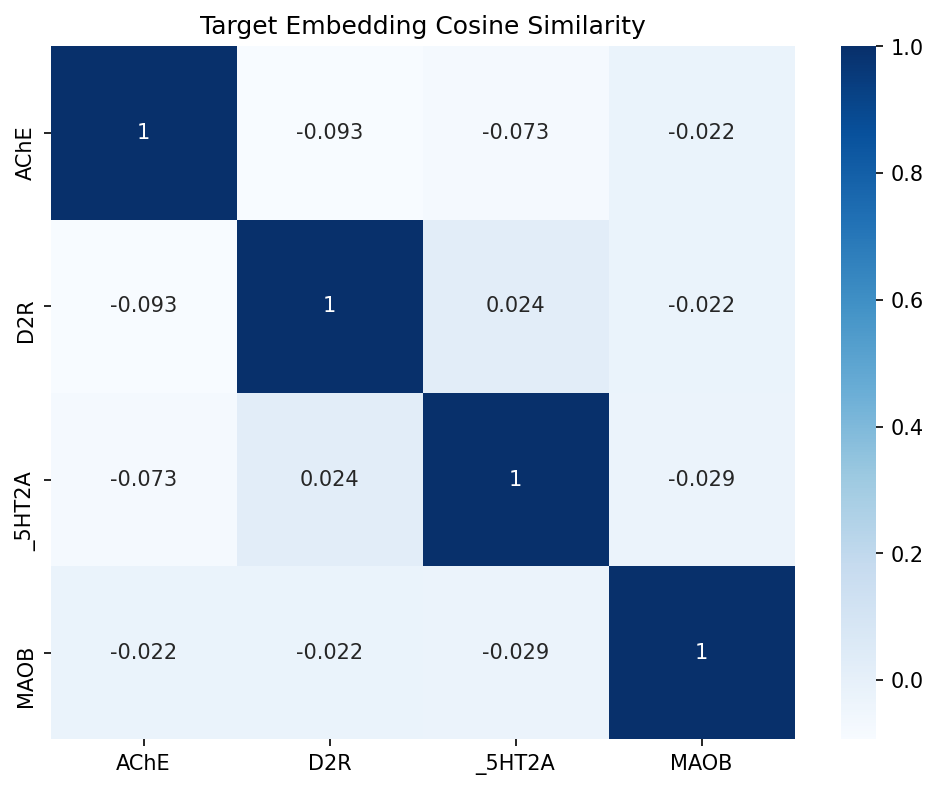

In [55]:
# plot the similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

similarity_matrix = np.zeros((len(target_embedding), len(target_embedding)))

for i, target1 in enumerate(target_embedding):
    for j, target2 in enumerate(target_embedding):
        similarity_matrix[i, j] = similarity[f"{target1}_{target2}"].item()

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=target_embedding.keys(), 
    yticklabels=target_embedding.keys()
)

plt.title('Target Embedding Cosine Similarity')

plt.show()

In [56]:
# egfr_sequence = """MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEV
# VLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALA
# VLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDF
# QNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGC
# TGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYV
# VTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFK
# NCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAF
# ENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKL
# FGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCN
# LLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVM
# GENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVV
# ALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGS
# GAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGI
# CLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAA
# RNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSY
# GVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPK
# FRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQ
# QGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTED
# SIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLN
# TVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRV
# APQSSEFIGA"""

# htr1a_sequence = """MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTLIFCAVLGNACVVAA
# IALERSLQNVANYLIGSLAVTDLMVSVLVLPMAALYQVLNKWTLGQVTCDLFIALDVLCC
# TSSILHLCAIALDRYWAITDPIDYVNKRTPRRAAALISLTWLIGFLISIPPMLGWRTPED
# RSDPDACTISKDHGYTIYSTFGAFYIPLLLMLVLYGRIFRAARFRIRKTVKKVEKTGADT
# RHGASPAPQPKKSVNGESGSRNWRLGVESKAGGALCANGAVRQGDDGAALEVIEVHRVGN
# SKEHLPLPSEAGPTPCAPASFERKNERNAEAKRKMALARERKTVKTLGIIMGTFILCWLP
# FFIVALVLPFCESSCHMPTLLGAIINWLGYSNSLLNPVIYAYFNKDFQNAFKKIIKCKFC
# RQ"""

# s1pr1_sequence = """MGPTSVPLVKAHRSSVSDYVNYDIIVRHYNYTGKLNISADKENSIKLTSVVFILICCFII
# LENIFVLLTIWKTKKFHRPMYYFIGNLALSDLLAGVAYTANLLLSGATTYKLTPAQWFLR
# EGSMFVALSASVFSLLAIAIERYITMLKMKLHNGSNNFRLFLLISACWVISLILGGLPIM
# GWNCISALSSCSTVLPLYHKHYILFCTTVFTLLLLSIVILYCRIYSLVRTRSRRLTFRKN
# ISKASRSSEKSLALLKTVIIVLSVFIACWAPLFILLLLDVGCKVKTCDILFRAEYFLVLA
# VLNSGTNPIIYTLTNKEMRRAFIRIMSCCKCPSGDSAGKFKRPIIAGMEFSRSKSDNSSH
# PQKDEGDNPETIMSSGNVNSSS"""

In [57]:
# from Bio.Seq import Seq
# from Bio.Align import PairwiseAligner

# egfr_seq = Seq(egfr_sequence.replace('\n', ''))
# htr1a_seq = Seq(htr1a_sequence.replace('\n', ''))
# s1pr1_seq = Seq(s1pr1_sequence.replace('\n', ''))

# targets_seq = {
#     "EGFR": egfr_seq,
#     "HTR1A": htr1a_seq,
#     "S1PR1": s1pr1_seq
# }

# egfr_seq

In [58]:
# aligner = PairwiseAligner()

# for target1 in targets_seq:
#     for target2 in targets_seq:
#         alignments = aligner.align(targets_seq[target1], targets_seq[target2])
#         best_alignment = alignments[0]

#         print(f"Alignment between {target1} and {target2}")
#         # print(best_alignment)

#         # Calculate sequence similarity as the fraction of identical residues
#         similarity = best_alignment.score / len(targets_seq[target1])

#         print(f"Similarity: {similarity:.2f}")

# # plot the similarity matrix
# similarity_matrix = np.zeros((3, 3))

# for i, target1 in enumerate(targets_seq):
#     for j, target2 in enumerate(targets_seq):
#         alignments = aligner.align(targets_seq[target1], targets_seq[target2])
#         best_alignment = alignments[0]

#         similarity_matrix[i, j] = best_alignment.score / len(targets_seq[target1])

# plt.figure(figsize=(8, 6), dpi=150)

# sns.heatmap(
#     similarity_matrix, 
#     annot=True, cmap='Blues',
#     xticklabels=targets_seq.keys(), 
#     yticklabels=targets_seq.keys()
# )

# plt.title('Target Protein Sequence Similarity')

# plt.show()

In [59]:
# from rdkit import RDLogger

# RDLogger.DisableLog('rdApp.*')

# import lightgbm as lgb
# from process_training_data import get_fp

# # load qsar models for each target
# targets = ["EGFR", "HTR1A", "S1PR1"]

# model = dict()

# for target in targets:
#     model[target] = lgb.Booster(model_file=f'./model/{target}.txt')

# # load active molecules dataset for each target
# active_molecules = dict()

# for target in targets:
#     X = np.load('npy/{}_X.npy'.format(target))
#     y = np.load('npy/{}_y.npy'.format(target))

#     print(X.shape, y.shape)

#     res = pd.DataFrame(X, columns=list(range(len(X[0]))))
#     res['activity'] = y

#     # res_active = res[res['activity'] >= 6.5]

#     active_molecules[target] = res

# # for each model, predict the activity of the active molecules datasets
# predicted_activities = dict()

# for target_model in targets:
#     predicted_activities[target_model] = dict()

#     for target_dataset in targets:
#         X = active_molecules[target_dataset].drop(columns=['activity']).values
#         y = active_molecules[target_dataset]['activity'].values

#         predicted_activities[target_model][target_dataset] = model[target_model].predict(X)

# # plot a scatter plot of the predicted activities for each target
# # each row is a target model, each column is a target dataset
# # the x axis is the predicted activity of the target model, the y axis is the predicted activity of the target dataset
# fig, axes = plt.subplots(3, 3, figsize=(14, 12))

# for i, target_model in enumerate(targets):
#     for j, target_dataset in enumerate(targets):
#         axes[i, j].scatter(
#             predicted_activities[target_model][target_dataset], 
#             active_molecules[target_dataset]['activity'], 
#             # predicted_activities[target_dataset][target_dataset],
#             alpha=0.3,
#             color=pal[i]
#         )

#         axes[i, j].set_title(f'{target_model} model vs {target_dataset} dataset')
#         axes[i, j].set_xlabel(f'{target_model} predicted activity (pXC50)')
#         axes[i, j].set_ylabel(f'{target_dataset} true activity (pXC50)')

#         # calculate the correlation coefficient
#         correlation = np.corrcoef(
#             predicted_activities[target_model][target_dataset], 
#             active_molecules[target_dataset]['activity']
#         )[0, 1]

#         axes[i, j].text(0.5, 0.9, f'Correlation: {correlation:.2f}', 
#                         horizontalalignment='center',
#                         verticalalignment='center',
#                         transform=axes[i, j].transAxes)


# plt.tight_layout()
# plt.show()

In [60]:
active_molecules_smiles = dict()
smiles_target = pd.read_csv("../data/chembl_active_compounds.smi", sep="\t", names=["SMILES", "target"])

targets_to_idx = {
    "AChE": 1,
    "D2R": 2,
    "D3R": 3,
    "_5HT2A": 4,
    "MAOB": 5,
}

for target in targets_to_idx:
    _id = targets_to_idx[target]
    smiles_target_id = smiles_target[smiles_target["target"] == _id]
    active_molecules_smiles[target] = smiles_target_id.sample(150)

active_molecules_smiles

{'AChE':                                                 SMILES  target
 196  Cc1ccc(/C=C2\CN(Cc3cccc(C)c3)C/C(=C\c3ccc(C)cc...       1
 7                [O-][S+]1CCN(c2nccc(NCc3ccccc3)n2)CC1       1
 290             COc1cccc2cc[n+](-c3ccccc3Cl)cc12.[Br-]       1
 140  NC(=O)c1cc[n+](-c2ccc(-[n+]3ccc(/C=N/O)cc3)s2)...       1
 312               O=C(CCCCCCCCc1ccc(O)cc1)c1c(O)cccc1O       1
 ..                                                 ...     ...
 17   COc1ccc(CCC(=O)c2c(OC)cc(O)c([C@@H](c3ccc(O)cc...       1
 192  Cc1ccc(/C=C2/CNCC3=C2N=C2SC=C(c4ccc5ccccc5c4)N...       1
 198                           CCO[P@](=O)(SCC)c1ccccc1       1
 222               O=C1NC(=S)NC(=O)C1=CNNC(=S)Nc1ccccc1       1
 160   COc1cc(CN2CCC(CCC(=O)c3cc(Cl)c(N)cc3OC)CC2)ccc1O       1
 
 [150 rows x 2 columns],
 'D2R':                                                 SMILES  target
 526               Cc1cccc(NC(=O)CN2CCN(c3ncccn3)CC2)c1       2
 395   CCCNC(=O)Oc1cccc2c1-c1cccc3c1[C@@H](C2)N(CCC)CC3       

Text(0.5, 1.0, 'Tanimoto Similarity between Active Molecules Datasets')

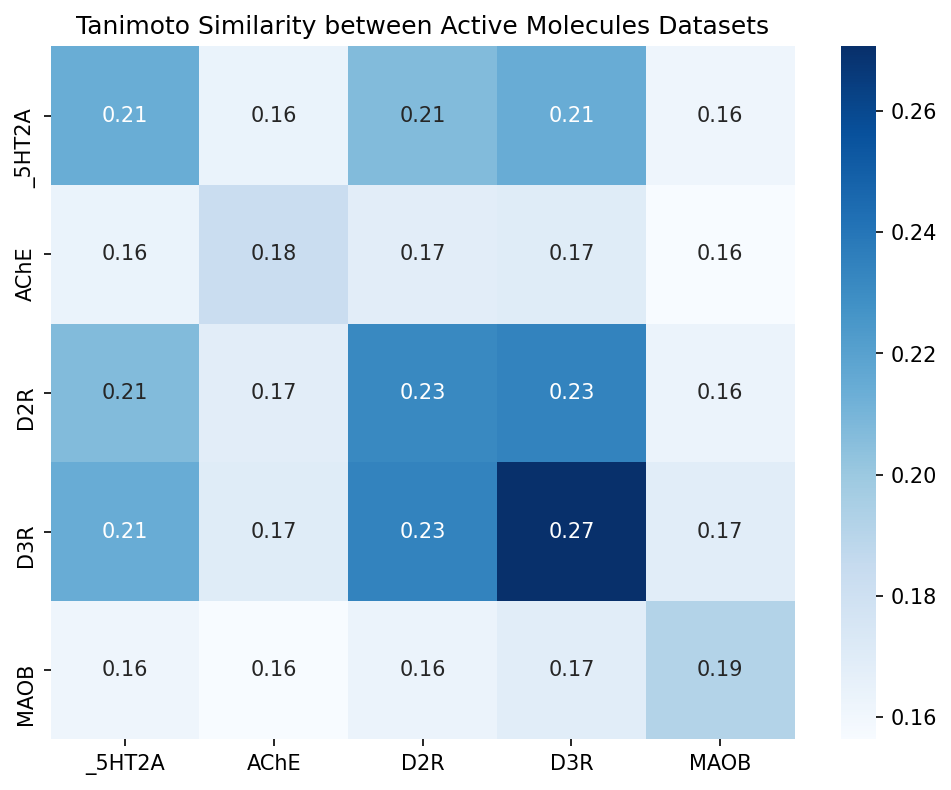

In [61]:
# import tanimoto bulk similarity
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles

# for each target, calculate the tanimoto similarity between the active molecules datasets
tanimoto_similarity = dict()

for target1 in targets:
    tanimoto_similarity[target1] = dict()

    for target2 in targets:
        tanimoto_similarity[target1][target2] = list()

        for smiles1 in active_molecules_smiles[target1]['SMILES']:
            mol1 = MolFromSmiles(smiles1)
            fp1 = AllChem.GetMorganFingerprint(mol1, 2)

            for smiles2 in active_molecules_smiles[target2]['SMILES']:
                mol2 = MolFromSmiles(smiles2)
                fp2 = AllChem.GetMorganFingerprint(mol2, 2)

                tanimoto_similarity[target1][target2].append(DataStructs.TanimotoSimilarity(fp1, fp2))

# plot the tanimoto similarity matrix
similarity_matrix = np.zeros((len(targets), len(targets)))

for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        similarity_matrix[i, j] = np.mean(tanimoto_similarity[target1][target2])

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=targets, 
    yticklabels=targets
)

plt.title('Tanimoto Similarity between Active Molecules Datasets')

#### Tree MAP

In [62]:
all_active_molecules = pd.DataFrame()

targets = ['_5HT2A', 'AChE', 'D2R', 'MAOB']
N = 4000

for target in targets:
    mols_df = active_molecules_smiles[target]
    mols_df['target'] = target

    all_active_molecules = pd.concat([all_active_molecules, mols_df])

all_active_molecules

,SMILES,target
997,COc1ccc(CN2CC=C(c3c[nH]c4ccccc34)CC2)cc1,_5HT2A
919,CCOC(=O)Cc1nn(CNC(=O)CCN2CCN(c3cccc(C)c3C)CC2)...,_5HT2A
1017,CN1CCN(c2ccnc(NCCc3ccccc3)n2)CC1,_5HT2A
846,CCN(C)C(=O)N[C@H]1CC[C@H](CCN2CCc3ccc(Cl)cc3[C...,_5HT2A
949,Fc1ccc(Nc2nc(N3CCN(c4ccccc4)CC3)nc3[nH]ncc23)cc1,_5HT2A
...,...,...
1189,C#CCOc1ccc(-c2cc(-c3ccc(OCC#C)cc3)nc(N)n2)cc1,MAOB
1167,COc1cc(O)c2c(=O)c3c(O)ccc(O)c3oc2c1,MAOB
1252,COc1ccc2cc(/C=N/Nc3nc(-c4cc5ccccc5o4)cs3)ccc2c1,MAOB
1110,C#CCn1c(=O)c2c(nc3n2CCCN3c2ccc(C(C)C)cc2)n(C)c1=O,MAOB


In [63]:
for i, row in all_active_molecules.iterrows():
    print(row['SMILES'], row['target'])
    print(row)
    break

COc1ccc(CN2CC=C(c3c[nH]c4ccccc34)CC2)cc1 _5HT2A
SMILES    COc1ccc(CN2CC=C(c3c[nH]c4ccccc34)CC2)cc1
target                                      _5HT2A
Name: 997, dtype: object


In [64]:
training_mols = pd.read_csv(
    "../data/chembl_active_compounds.smi", sep="\t", names=["SMILES", "target"]
)
training_mols["target"] = training_mols["target"].replace(
    # {1: "EGFR", 2: "HTR1A", 3: "S1PR1"}
    {1: "AChE", 2: "D2R", 3: "D3R", 4: "_5HT2A", 5: "MAOB"}
)

targets = ["AChE", "D2R", "_5HT2A", "MAOB"]
ACT_TYPE = "Activity"

training_mols_ts = training_mols[training_mols["target"].isin(targets)]

for target in targets:
    transformers = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{target}.csv')

    smiles_top_500 = transformers.drop_duplicates(subset="SMILES").nlargest(N, f"{target}_{ACT_TYPE}")

    smiles_top_500['target'] = f"{target} (generated)"
    generated_mols = smiles_top_500[["SMILES", "target"]]

    training_mols_ts = pd.concat([training_mols_ts, generated_mols])

training_mols_ts["target"].value_counts()

AChE (generated)      4000
D2R (generated)       4000
_5HT2A (generated)    4000
MAOB (generated)      4000
AChE                   331
D2R                    289
MAOB                   250
_5HT2A                 209
Name: target, dtype: int64

In [65]:
# add multi-target generated molecules
agg = "SUM"

multi_targets = [
    (f"AChE_MAOB_{agg}", "AChE", "MAOB"),
    (f"D2R__5HT2A_{agg}", "D2R", "_5HT2A"),
    # (f"D2R_D3R_{agg}", "D2R", "D3R")
]

training_mols_mt = training_mols_ts.copy()

for (mt, t1, t2) in multi_targets:
    transformers = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{mt}.csv')

    smiles_top_500 = transformers.drop_duplicates(subset="SMILES").nlargest(N, f"{t1}_{t2}_{ACT_TYPE}")

    smiles_top_500['target'] = f"{mt} (generated)"
    generated_mols = smiles_top_500[["SMILES", "target"]]

    training_mols_mt = pd.concat([training_mols_mt, generated_mols])

In [66]:
training_mols_mt["target"].value_counts()

AChE (generated)              4000
D2R (generated)               4000
_5HT2A (generated)            4000
MAOB (generated)              4000
AChE_MAOB_SUM (generated)     4000
D2R__5HT2A_SUM (generated)    4000
AChE                           331
D2R                            289
MAOB                           250
_5HT2A                         209
Name: target, dtype: int64

In [67]:
# !conda install -c tmap tmap -y
# !pip install faerun mhfp

In [68]:
import numpy as np
import tmap as tm
import scipy.stats as ss
from rdkit.Chem import AllChem
from mhfp.encoder import MHFPEncoder
from faerun import Faerun
from matplotlib.colors import ListedColormap


filter_types = [
    # "AChE",
    # "MAOB",
    # "AChE (generated)",
    # "MAOB (generated)",
    # "AChE_MAOB_SUM (generated)",
    "D2R",
    "_5HT2A",
    "D2R (generated)",
    "_5HT2A (generated)",
    "D2R__5HT2A_SUM (generated)",
]

colors = {
    "AChE": "lightgreen",
    "AChE (generated)": "darkgreen",
    "D2R": "orange",
    "D2R (generated)": "darkorange",
    "_5HT2A": "blue",
    "_5HT2A (generated)": "darkblue",
    "MAOB": "#ff9a98", # "lightred",
    "MAOB (generated)": "darkred",
    # "AChE_MAOB_SUM (generated)": "#FF69B4",
    "AChE_MAOB_SUM (generated)": "#FF88FF",
    # "D2R__5HT2A_SUM (generated)": "green",
    "D2R__5HT2A_SUM (generated)": "#00ff00",
}

def main():
    """ Main funciton """
    # df = all_active_molecules
    df = training_mols_mt.query("target in @filter_types")

    enc = MHFPEncoder(1024)
    lf = tm.LSHForest(1024, 64)

    fps = []
    # hac = []
    # c_frac = []
    # ring_atom_frac = []
    # largest_ring_size = []

    for i, row in df.iterrows():
        if i != 0 and i % 1000 == 0:
            print(f"{i / len(df):0.2%} done")
        mol = AllChem.MolFromSmiles(row["SMILES"])
        # atoms = mol.GetAtoms()
        # size = mol.GetNumHeavyAtoms()
        # n_c = 0
        # n_ring_atoms = 0
        # for atom in atoms:
        #     if atom.IsInRing():
        #         n_ring_atoms += 1
        #     if atom.GetSymbol().lower() == "c":
        #         n_c += 1

        # c_frac.append(n_c / size)
        # ring_atom_frac.append(n_ring_atoms / size)
        # sssr = AllChem.GetSymmSSSR(mol)
        # if len(sssr) > 0:
        #     largest_ring_size.append(max([len(s) for s in sssr]))
        # else:
        #     largest_ring_size.append(0)
        # hac.append(size)
        fps.append(tm.VectorUint(enc.encode_mol(mol)))

    lf.batch_add(fps)
    lf.index()

    # c_frak_ranked = ss.rankdata(np.array(c_frac) / max(c_frac)) / len(c_frac)

    cfg = tm.LayoutConfiguration()
    cfg.node_size = 1 / 26
    cfg.mmm_repeats = 2
    cfg.sl_extra_scaling_steps = 5
    cfg.k = 20
    cfg.sl_scaling_type = tm.RelativeToAvgLength
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

    type_labels, type_data = Faerun.create_categories(df["target"])

    cmap = ListedColormap([colors[t[1]] for t in type_labels])

    f = Faerun(view="front", coords=False, clear_color='#ffffff')
    f.add_scatter(
        "np_atlas",
        {
            "x": x,
            "y": y,
            "c": [
                type_data,
            ],
            "labels": df["SMILES"],
        },
        shader="smoothCircle",
        point_scale=2.0,
        max_point_size=20,
        legend_labels=[type_labels],
        categorical=[True],
        colormap=[cmap],
        series_title=[
            "Type",
        ],
        has_legend=True,
    )
    f.add_tree("np_atlas_tree", {"from": s, "to": t}, point_helper="np_atlas")
    f.plot(template="smiles")
    return lf

lf = main()

8.00% done
184.03% done
56.01% done
8.00% done
24.00% done


/home/arthurcerveira/miniconda3/envs/aidd/lib/python3.9/site-packages/mhfp/encoder.py:297: UserWarning: The length of the shingling is 0, which results in an empty set and an all zero folded fingerprint.
  warnings.warn("The length of the shingling is 0, which results in an empty set and an all zero folded fingerprint.")


152.02% done
8.00% done
40.01% done
8.00% done
104.02% done


/home/arthurcerveira/cMolGPT-Brain-Diseases/scripts/index.html

In [69]:
type_labels, type_data = Faerun.create_categories(training_mols["target"])
type_labels

[(0, 'AChE'), (1, 'D2R'), (2, 'D3R'), (3, 'MAOB'), (4, '_5HT2A')]

In [70]:
from tqdm import tqdm

# df = all_active_molecules
df = training_mols_mt.query("target in @filter_types").reset_index(drop=True)

enc = MHFPEncoder(1024)
# d = dimensionality of the MinHashe vectors to be added
# l = number of prefix trees used when indexing data
lf = tm.LSHForest(d=1024, l=64)

fps = []

for smiles in tqdm(df["SMILES"]):
    mol = AllChem.MolFromSmiles(smiles)
    fps.append(tm.VectorUint(enc.encode_mol(mol)))

lf.batch_add(fps)
lf.index()

# Reference: https://github.com/reymond-group/tmap/blob/c74b718a86843292ab6aad91b99196b0133faac9/src/_tmap/layout.hh#L181
cfg = tm.LayoutConfiguration()

# The size of the nodes, which affects the magnitude of their repelling force.
# Decreasing this value generally resolves overlaps in a very crowded tree.
cfg.node_size = 1 / 26

# Number of repeats of the per-level layout algorithm
cfg.mmm_repeats = 2

# Sets the number of repeats of the scaling.
cfg.sl_extra_scaling_steps = 5

# The number of nearest neighbors used to create the k-nearest neighbor graph
cfg.k = 20

# Defines the (relative) scale of the graph
cfg.sl_scaling_type = tm.RelativeToAvgLength

# Returns: The x and y coordinates of the vertices, the ids of the vertices spanning the edges, and information on the graph
x, y, s, t, graph_properties = tm.layout_from_lsh_forest(lf, cfg)

type_labels, type_data = Faerun.create_categories(df["target"])

cmap = ListedColormap([colors[t[1]] for t in type_labels])

100%|██████████| 12498/12498 [00:54<00:00, 230.31it/s]


In [71]:
len(graph_properties.adjacency_list), len(df)

(12498, 12498)

In [72]:
# pip install networkx --force-reinstall --no-deps --upgrade --user

In [73]:
import networkx as nx
from collections import defaultdict
import pandas as pd

# Assume G is your graph and class_dict maps each node to its class
G = nx.Graph()
class_dict = {}

for i, row in df.iterrows():
    G.add_node(i)
    class_dict[i] = row['target']

for i, adj in enumerate(graph_properties.adjacency_list):
    # adj = adj[0]
    for j in adj:
        # G.add_edge(i, j[0], weight=j[1])
        G.add_edge(i, j[0])

node_classes = class_dict
nx.set_node_attributes(G, node_classes, 'class')
print(len(G.nodes), len(G.edges))

12498 12496


In [74]:
# Calculate betweenness centrality for all nodes
betweenness_centrality = nx.betweenness_centrality(G)

# Initialize a dictionary to store class pair betweenness centrality
class_pair_betweenness = defaultdict(float)

# Aggregate betweenness centrality by class pairs
for node, centrality in betweenness_centrality.items():
    node_class = G.nodes[node]['class']
    for neighbor in G.neighbors(node):
        neighbor_class = G.nodes[neighbor]['class']
        if node_class != neighbor_class:  # Only consider inter-class pairs
            class_pair = tuple(sorted([node_class, neighbor_class]))
            class_pair_betweenness[class_pair] += centrality

# Output the betweenness centrality for each class pair
for class_pair, centrality in class_pair_betweenness.items():
    print(f"Betweenness centrality between classes {class_pair}: {centrality}")

Betweenness centrality between classes ('D2R', '_5HT2A'): 0.5456901333656828
Betweenness centrality between classes ('D2R', 'D2R (generated)'): 5.5804012937496745
Betweenness centrality between classes ('D2R', 'D2R__5HT2A_SUM (generated)'): 3.762352990325876
Betweenness centrality between classes ('D2R', '_5HT2A (generated)'): 2.974352282447915
Betweenness centrality between classes ('D2R (generated)', '_5HT2A'): 0.1624068777787078
Betweenness centrality between classes ('_5HT2A', '_5HT2A (generated)'): 0.954659681703891
Betweenness centrality between classes ('D2R__5HT2A_SUM (generated)', '_5HT2A'): 0.4784272425125951
Betweenness centrality between classes ('D2R (generated)', '_5HT2A (generated)'): 21.670117166147868
Betweenness centrality between classes ('D2R (generated)', 'D2R__5HT2A_SUM (generated)'): 44.83124473561303
Betweenness centrality between classes ('D2R__5HT2A_SUM (generated)', '_5HT2A (generated)'): 56.70575113443398


In [77]:
.value_counts()

D2R (generated)               4000
_5HT2A (generated)            4000
D2R__5HT2A_SUM (generated)    4000
D2R                            289
_5HT2A                         209
Name: target, dtype: int64

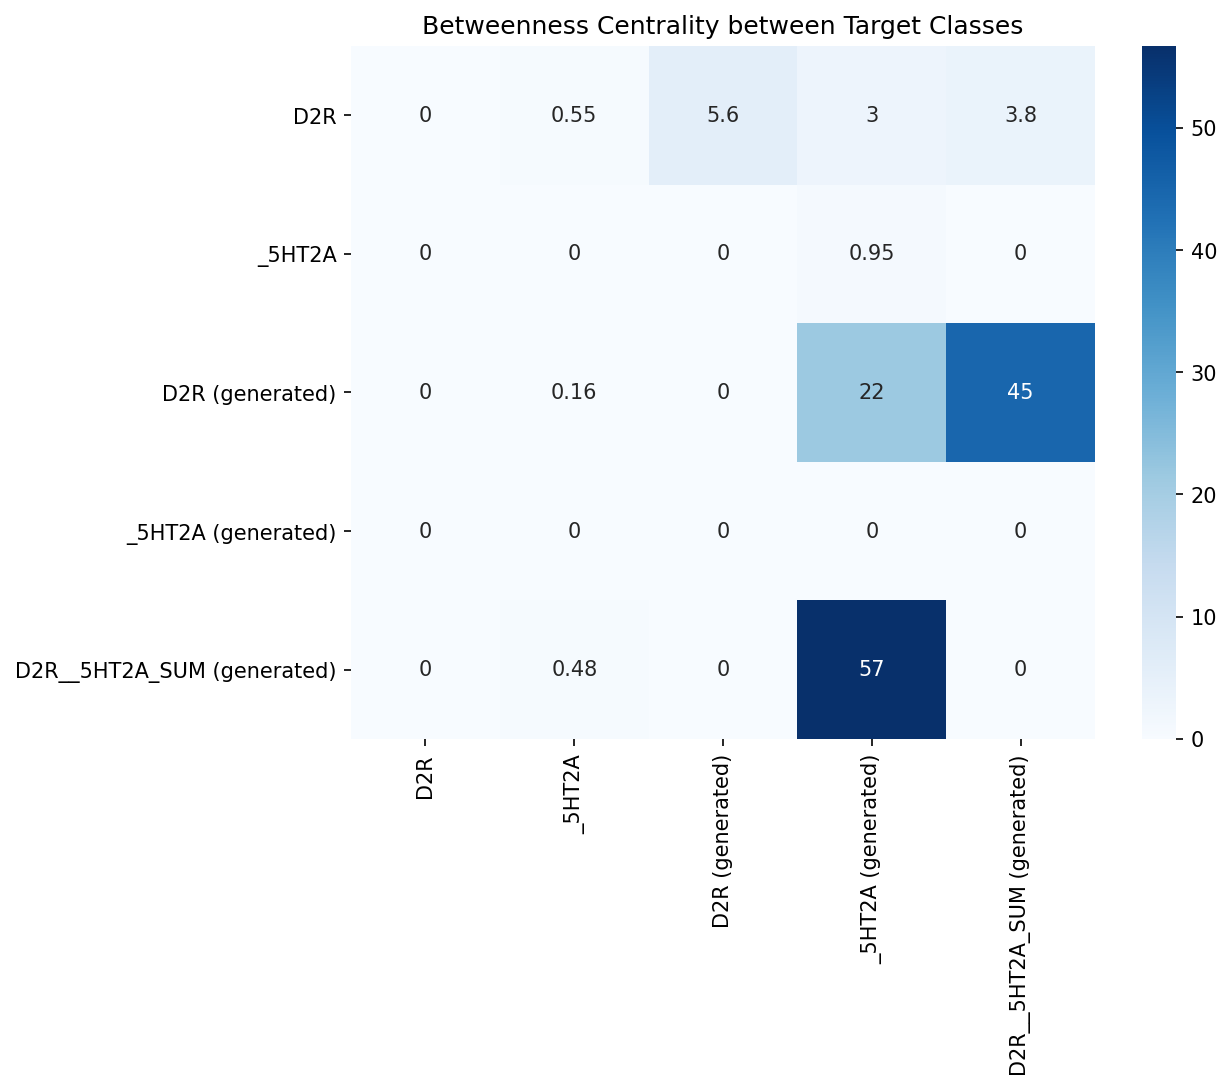

In [78]:
# convert class_pair_betweenness into a matrix
targets = df["target"].unique()

class_pair_betweenness_matrix = np.zeros((len(targets), len(targets)))

for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        class_pair_betweenness_matrix[i, j] = class_pair_betweenness[(target1, target2)]

plt.figure(figsize=(8, 6), dpi=150)
sns.heatmap(
    class_pair_betweenness_matrix,
    annot=True,
    cmap='Blues',
    xticklabels=targets,
    yticklabels=targets
)

plt.title('Betweenness Centrality between Target Classes')

plt.show()

In [38]:
def compute_class_metrics(G, node_classes):
    class_metrics = {}
    classes = set(node_classes.values())
    
    for class_name in classes:
        class_nodes = [n for n in G.nodes if G.nodes[n]['class'] == class_name]
        class_edges = G.subgraph(class_nodes).number_of_edges()
        possible_intra_class_edges = len(class_nodes) * (len(class_nodes) - 1) / 2
        intra_class_density = class_edges / possible_intra_class_edges if possible_intra_class_edges > 0 else 0
        
        inter_class_edges = 0
        possible_inter_class_edges = 0
        
        for other_class_name in classes:
            if other_class_name != class_name:
                other_class_nodes = [n for n in G.nodes if G.nodes[n]['class'] == other_class_name]
                possible_inter_class_edges += len(class_nodes) * len(other_class_nodes)
                inter_class_edges += len([e for e in G.edges if (G.nodes[e[0]]['class'], G.nodes[e[1]]['class']) in [(class_name, other_class_name), (other_class_name, class_name)]])
        
        inter_class_density = inter_class_edges / possible_inter_class_edges if possible_inter_class_edges > 0 else 0
        
        class_metrics[class_name] = {
            'intra_class_density': intra_class_density,
            'inter_class_density': inter_class_density
        }
    
    return class_metrics

# Compute modularity contribution
def compute_class_modularity(G, node_classes):
    modularity_dict = {}
    communities = [list(filter(lambda x: node_classes[x] == c, G.nodes)) for c in set(node_classes.values())]
    modularity = nx.algorithms.community.quality.modularity(G, communities)
    
    for community in communities:
        subgraph = G.subgraph(community)
        class_name = node_classes[community[0]]
        subgraph_modularity = nx.algorithms.community.quality.modularity(subgraph, [community])
        modularity_dict[class_name] = subgraph_modularity
    
    return modularity, modularity_dict

class_metrics = compute_class_metrics(G, node_classes)
modularity, class_modularity_dict = compute_class_modularity(G, node_classes)

df = pd.DataFrame(class_metrics).T

print("Class Metrics:")
for class_name, metrics in class_metrics.items():
    print(f"Class {class_name}:")
    print(f"  Intra-class Density: {metrics['intra_class_density']}")
    print(f"  Inter-class Density: {metrics['inter_class_density']}")

print(f"Overall Modularity: {modularity}")
print("Class Modularity Contributions:")
for class_name, mod_value in class_modularity_dict.items():
    print(f"  Class {class_name} Modularity: {mod_value}")

Class Metrics:
Class D2R (generated):
  Intra-class Density: 0.00023168292073018253
  Inter-class Density: 0.00011543892680630736
Class _5HT2A:
  Intra-class Density: 0.00381854987118145
  Inter-class Density: 0.00010512377156059354
Class _5HT2A (generated):
  Intra-class Density: 0.0002713178294573643
  Inter-class Density: 0.00010823134855260061
Class D2R:
  Intra-class Density: 0.0030036524413687045
  Inter-class Density: 0.00013008725482166
Class D2R__5HT2A_SUM (generated):
  Intra-class Density: 0.00018829707426856713
  Inter-class Density: 0.00015256530948458462
Overall Modularity: 0.15423784202494092
Class Modularity Contributions:
  Class D2R (generated) Modularity: 0.0
  Class _5HT2A Modularity: 1.1102230246251565e-16
  Class _5HT2A (generated) Modularity: 0.0
  Class D2R Modularity: 0.0
  Class D2R__5HT2A_SUM (generated) Modularity: 0.0


In [39]:
print(df.assign(
    Intra_class_Density=df['intra_class_density'].map('{:.2e}'.format),
    Inter_class_Density=df['inter_class_density'].map('{:.2e}'.format)
).drop(columns=['intra_class_density', 'inter_class_density']).to_markdown())

|                            |   Intra_class_Density |   Inter_class_Density |
|:---------------------------|----------------------:|----------------------:|
| D2R (generated)            |              0.000232 |              0.000115 |
| _5HT2A                     |              0.00382  |              0.000105 |
| _5HT2A (generated)         |              0.000271 |              0.000108 |
| D2R                        |              0.003    |              0.00013  |
| D2R__5HT2A_SUM (generated) |              0.000188 |              0.000153 |


In [40]:
def compute_conductance(G, node_classes):
    conductance_dict = {}
    classes = set(node_classes.values())
    
    for class_name in classes:
        # Nodes in the current class
        class_nodes = [n for n in G.nodes if G.nodes[n]['class'] == class_name]
        
        # Subgraph induced by class nodes
        subgraph = G.subgraph(class_nodes)
        
        # Number of edges within the class
        internal_edges = len(list(subgraph.edges()))
        
        # Total number of edges connected to class nodes
        total_edges = sum([G.degree(n) for n in class_nodes]) / 2
        
        # Number of edges connecting class nodes to nodes outside the class
        boundary_edges = sum([len([e for e in G.edges(n) if e[0] in class_nodes or e[1] in class_nodes]) for n in class_nodes]) / 2 - internal_edges
        
        # Conductance calculation
        if total_edges == 0:
            conductance = 0
        else:
            conductance = boundary_edges / total_edges
        
        conductance_dict[class_name] = conductance
    
    return conductance_dict

# Compute conductance for each class
conductance = compute_conductance(G, node_classes)

# Print the conductance values
for class_name, value in conductance.items():
    print(f'Class {class_name} Conductance: {value}')

Class D2R (generated) Conductance: 0.5142857142857142
Class _5HT2A Conductance: 0.6192660550458715
Class _5HT2A (generated) Conductance: 0.45878538471131064
Class D2R Conductance: 0.6473906911142454
Class D2R__5HT2A_SUM (generated) Conductance: 0.632593315442791


In [39]:
# Initialize a dictionary to store edges between class pairs
class_pair_edges = defaultdict(lambda: defaultdict(int))
total_edges_per_class_pair = defaultdict(lambda: defaultdict(int))

# Count edges between class pairs
for node in G.nodes():
    node_class = class_dict[node]
    for neighbor in G.neighbors(node):
        neighbor_class = class_dict[neighbor]
        total_edges_per_class_pair[node_class][neighbor_class] += 1
        if node_class != neighbor_class:
            class_pair_edges[node_class][neighbor_class] += 1
            class_pair_edges[neighbor_class][node_class] += 1  # Since it's an undirected graph

# Calculate neighboring index for each pair of classes
neighboring_index = defaultdict(lambda: defaultdict(float))
for class_i in total_edges_per_class_pair:
    for class_j in total_edges_per_class_pair[class_i]:
        if total_edges_per_class_pair[class_i][class_j] > 0:
            neighboring_index[class_i][class_j] = class_pair_edges[class_i][class_j] / total_edges_per_class_pair[class_i][class_j]

print("Neighboring Index for each pair of classes:")
for class_i in neighboring_index:
    for class_j in neighboring_index[class_i]:
        print(f"({class_i}, {class_j}): {neighboring_index[class_i][class_j]:.2f}")

Neighboring Index for each pair of classes:
(D2R, _5HT2A): 2.00
(D2R, D2R (generated)): 2.00
(D2R, D2R__5HT2A_SUM (generated)): 2.00
(D2R, D2R): 0.00
(D2R, _5HT2A (generated)): 2.00
(_5HT2A, D2R): 2.00
(_5HT2A, D2R (generated)): 2.00
(_5HT2A, _5HT2A (generated)): 2.00
(_5HT2A, _5HT2A): 0.00
(_5HT2A, D2R__5HT2A_SUM (generated)): 2.00
(D2R (generated), _5HT2A (generated)): 2.00
(D2R (generated), D2R (generated)): 0.00
(D2R (generated), D2R__5HT2A_SUM (generated)): 2.00
(D2R (generated), _5HT2A): 2.00
(D2R (generated), D2R): 2.00
(_5HT2A (generated), D2R__5HT2A_SUM (generated)): 2.00
(_5HT2A (generated), D2R (generated)): 2.00
(_5HT2A (generated), _5HT2A (generated)): 0.00
(_5HT2A (generated), _5HT2A): 2.00
(_5HT2A (generated), D2R): 2.00
(D2R__5HT2A_SUM (generated), D2R (generated)): 2.00
(D2R__5HT2A_SUM (generated), D2R__5HT2A_SUM (generated)): 0.00
(D2R__5HT2A_SUM (generated), _5HT2A (generated)): 2.00
(D2R__5HT2A_SUM (generated), D2R): 2.00
(D2R__5HT2A_SUM (generated), _5HT2A): 2.00


In [73]:
import networkx as nx
from collections import defaultdict

# Assume G is your graph and class_dict maps each node to its class
# G = nx.Graph()
# class_dict = {}

# Add edges and node classes to the graph G and class_dict...

# Initialize dictionaries to store volume and cut size for each class
class_volume = defaultdict(int)
class_cut = defaultdict(int)

# Calculate volume and cut size for each class
for node in G.nodes():
    node_class = class_dict[node]
    for neighbor in G.neighbors(node):
        neighbor_class = class_dict[neighbor]
        class_volume[node_class] += 1  # Increment volume for the node's class
        if node_class != neighbor_class:
            class_cut[node_class] += 1  # Increment cut size if neighbor is in a different class

# Compute conductance for each class
conductance = {}
for cls in class_volume:
    if class_volume[cls] > 0:
        conductance[cls] = class_cut[cls] / min(class_volume[cls], 2 * (len(G.edges) - class_volume[cls]))

# Print conductance for each class
print("Conductance for each class:")
for cls, cond in conductance.items():
    print(f"Class {cls}: {cond:.4f}")

Conductance for each class:
Class D2R: 0.6474
Class _5HT2A: 0.6193
Class D2R (generated): 0.5143
Class _5HT2A (generated): 0.4588
Class D2R__5HT2A_SUM (generated): 0.6326


Pairwise Conductance Matrix:


<AxesSubplot:>

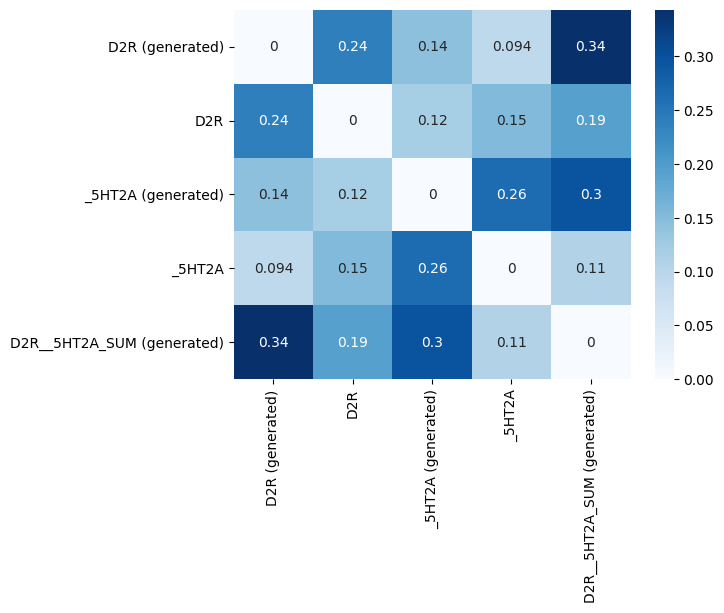

In [75]:
def compute_pairwise_conductance(G, class_dict):
    # Get unique classes
    classes = list(set(class_dict.values()))
    
    # Initialize dictionaries to store volumes and cut sizes for class pairs
    class_pair_cut = defaultdict(lambda: defaultdict(int))
    class_pair_volume = defaultdict(lambda: defaultdict(int))
    
    # Calculate volume and cut size for each pair of classes
    for node in G.nodes():
        node_class = class_dict[node]
        for neighbor in G.neighbors(node):
            neighbor_class = class_dict[neighbor]
            class_pair_volume[node_class][neighbor_class] += 1
            if node_class != neighbor_class:
                class_pair_cut[node_class][neighbor_class] += 1

    # Compute conductance for each pair of classes
    conductance_matrix = pd.DataFrame(index=classes, columns=classes, dtype=float)

    for class_i in classes:
        for class_j in classes:
            if class_pair_volume[class_i][class_j] > 0:
                cut = class_pair_cut[class_i][class_j]
                volume_i = sum(class_pair_volume[class_i].values())
                volume_j = sum(class_pair_volume[class_j].values())
                conductance_matrix.at[class_i, class_j] = cut / min(volume_i, volume_j)
            else:
                conductance_matrix.at[class_i, class_j] = None

    return conductance_matrix

# Compute pairwise conductance for each class
conductance_matrix = compute_pairwise_conductance(G, class_dict)

# Print conductance matrix
print("Pairwise Conductance Matrix:")
sns.heatmap(conductance_matrix, annot=True, cmap='Blues')

In [77]:
# Compute the clustering coefficient for each node
node_clustering = nx.clustering(G)

# Initialize a dictionary to store the clustering coefficients for each class
class_clustering = defaultdict(list)

# Group clustering coefficients by class
for node, clustering in node_clustering.items():
    node_class = class_dict[node]
    class_clustering[node_class].append(clustering)

# Calculate the average clustering coefficient for each class
avg_class_clustering = {cls: sum(coeffs) / len(coeffs) for cls, coeffs in class_clustering.items()}

# return avg_class_clustering

# Compute clustering coefficients for each class
# avg_class_clustering = compute_clustering_coefficient(G, class_dict)

# Print the average clustering coefficient for each class
print("Average Clustering Coefficient for each class:")
for cls, coeff in avg_class_clustering.items():
    print(f"Class {cls}: {coeff:.4f}")

Average Clustering Coefficient for each class:
Class D2R: 0.0000
Class _5HT2A: 0.0000
Class D2R (generated): 0.0000
Class _5HT2A (generated): 0.0000
Class D2R__5HT2A_SUM (generated): 0.0000
